# Multi-Layer Perceptron (MLP): Linearly Separable Data

Before we start investigating Multi-Layer Perceptron (MLP), let's pose some questions?

- What is a Multi-Layer Perceptron (MLP)?
- Is it designed with multiple Perceptrons?
- What is a Perceptron?

The MLP algorithm is inspired by the information processing mechanism of the human neural network. That's why MLP is also known as Artificial Neural Network (ANN).


Historically the first MLP/ANN model was proposed in 1962 by a Cornell psychologist named Frank Rosenblatt. It’s called Perceptron. The best way to understand the MLP/NN algorithm is to first understand how a Perceptron works. 

The Perceptron was the first pragmatic attempt to mimic human neural network for machine based learning. 
It was discovered shortly that Perceptron can do only trivial classification (on linearly separable data set). 
The MLP was invented in the process of circumventing the limitation of the Perceptron.

Thus to better understand the MLP, it is useful to first take a look at the Perceptron model. We will see that MLP is not a simple extension of the Perceptron model. The MLP is not designed by stacking multiple Perceptrons. 

Instead the initial design of the MLP was based on the Logistic Regression model. Therefore, before studying MLP we will perform a comparative analysis of the Perceptron and Logistic Regression models.


## Perceptron and Logistic Regression

The goal of this notebook is to study the Perceptron algorithm for a classification problem. Note that Perceptron is a **linear model**. Previously we studied the Logistic Regression model, which is also a linear classifier.

The main difference between Perceptron and Logistic Regression model is in the form of the activation function.
- Perceptron uses a step-function as the activation function.
- Logistic Regression model uses sigmoid function as the activation function.

The step-function is a **discontinuous** non-linear function, hence **not differentiable**. As a consequence it doesn't work well with the gradient descent algorithm. The perceptron weight update rule uses an approximation of the gradient of the loss function.

On the other hand, the sigmoid function is **continuous non-linear**, hence differentiable. Thus, its weight update rule could use the exact value of the gradient of the loss function.


Another significant difference between the Perceptron and Logistic Regression model is:

- Perceptron is not able to estimate class probabilities. 

- Logistic Regression classifier outputs class probabilities.

In this notebook, we will investigate the performance of both models on a linearly separable dataset. We will see that irrespective of their differences, for linearly seperable dataset both Perceptron and Logistic Regression have similar performance.

We will also see that these two models are unable to classify a non-linear data set. This limitation will lead us to study MLP/ANN models for pattern recognition (classification and regression) in non-linear data.

# Dataset


We will use the iris dataset, which is a multivariate data set. 

This is a famous dataset that contains the sepal and petal length and width of 150 iris flowers of three different species: Iris-Setosa, Iris-Versicolor, and Iris-Virginica

There are 4 features: 
- sepal length (cm)
- sepal width (cm)
- petal length (cm)
- petal width (cm)

Total number of samples: 150

The dataset is also known as Fisher's Iris data set as it was introduced by the British statistician and biologist Ronald Fisher in his 1936 paper "The use of multiple measurements in taxonomic problems as an example of linear discriminant analysis".


<img src="https://cse.unl.edu/~hasan/IrisFlowers.png" width=800 height=400>

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

## Function for Drawing Decision Boundary

To visualize the performce of the classifier we will draw decision boundary.

We use two functions for plotting decision boundary:
- Equation based
- Class probability based

Detail discussion on these two functions are given in the "Logistic Regression - Binary Classification" notebook.

In [2]:
def decision_boundary_equation_based(clf, X):
    
    xmin, xmax = X.min() - 1, X.max() + 1
    
    w = clf.coef_[0]
    b = clf.intercept_[0]

    x1 = np.linspace(xmin, xmax, 100)
    decision_boundary = -(b + w[0]*x1)/w[1]
    plt.plot(x1, decision_boundary, "k--", linewidth=3)
    
    
def decision_boundary_class_colored(clf, X, plotDistanceFromHyperplane=False, colorBar=False):
    
    # Get the min and max value of feature x1
    x1min, x1max = X[:,0].min() - 1, X[:, 0].max() + 1
    
    # Get the min and max value of feature x2
    x2min, x2max = X[:,1].min() - 1, X[:, 1].max() + 1
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    
    # Compute the class predictions for all new points
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    
    # Generate the contourf plot for the predictions
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.bwr, alpha=0.2)
    
    
    if(plotDistanceFromHyperplane == True):
    
        # Compute the signed distance of a sample to the hyperplane for all new points
        y_decision = clf.decision_function(X_new).reshape(x1.shape)

        # Generate the contourf plot for the distance of all points from the hyperplane
        plt.contourf(x1, x2, y_decision, cmap=plt.cm.bwr, alpha=0.2)
    
    if(colorBar==True):
        plt.colorbar()
    

## Load The Dataset

In [3]:
iris = load_iris()

print(iris.keys())
print(iris.feature_names)
print(iris.target_names)
print(iris.data.shape)

#print(iris.DESCR)

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 4)


## Create Data Matrix (X) and the Label Vector (y)

For the experimentation we used two features. This will help us to show the decision boundary in 2D.

We will build a classifier to detect the **Iris-Virginica type**. Thus, we code the target vector (y) accordingly.

In [4]:
X = iris["data"][:, (2, 3)]  # petal length, petal width

y = (iris["target"] == 2).astype(np.int)  # 1 if Iris-Virginica, else 0

## Split Data Into Training and Test Sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Logistic Regression

In [6]:
lg_reg_clf = LogisticRegression(solver='lbfgs')

lg_reg_clf.fit(X_train, y_train)

print("No. of Iterations:", lg_reg_clf.n_iter_ )
print("\nWeight Intercept:", lg_reg_clf.intercept_ )
print("Weight Coefficients:", lg_reg_clf.coef_ )


y_train_predicted = lg_reg_clf.predict(X_train)
#print(y_test_predict)

train_accuracy_logreg = np.mean(y_train_predicted == y_train)
print("\nTraining Accuracy: ", train_accuracy_logreg)

No. of Iterations: [14]

Weight Intercept: [-16.18936365]
Weight Coefficients: [[2.61476001 2.06836402]]

Training Accuracy:  0.9583333333333334


## Logistic Regression: Evaluation on Test Data

In [7]:
y_test_predicted = lg_reg_clf.predict(X_test)

test_accuracy_logreg = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy_logreg)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_test)


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))


Test Accuracy:  1.0

Test Confusion Matrix:
[[19  0]
 [ 0 11]]

Test Precision = 1.000000
Test Recall = 1.000000
Test F1 Score = 1.000000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



## Perceptron

The relevant hyperparameters for the sklearn Perceptron model are.

- penalty : None, ‘l2’ or ‘l1’ or ‘elasticnet’

        The penalty (aka regularization term) to be used. Defaults to None.

- alpha : float

        Constant that multiplies the regularization term if regularization is used. Defaults to 0.0001

- tol : The stopping criterion. Defaults to 1e-3.

- max_iter : The maximum number of passes over the training data (aka epochs). 


We can vary these two hyperparameter (use grid search). However, for this simple problem, 'l2' regularization works fine.

In [8]:
perceptron_clf = Perceptron(penalty='l2', alpha=.1)

perceptron_clf.fit(X_train, y_train)

print("No. of Iterations:", perceptron_clf.n_iter_ )
print("\nWeight Intercept:", perceptron_clf.intercept_ )
print("Weight Coefficients:", perceptron_clf.coef_ )


y_train_predicted = perceptron_clf.predict(X_train)


train_accuracy_perceptron = np.mean(y_train_predicted == y_train)
print("\nTraining Accuracy: ", train_accuracy_perceptron)

No. of Iterations: 8

Weight Intercept: [-13.]
Weight Coefficients: [[2.21184186 1.39074508]]

Training Accuracy:  0.9666666666666667


## Perceptron: Evaluation on Test Data

In [9]:
y_test_predicted = perceptron_clf.predict(X_test)

test_accuracy_perceptron = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy_perceptron)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_test)

f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))


Test Accuracy:  1.0

Test Confusion Matrix:
[[19  0]
 [ 0 11]]

Test Precision = 1.000000
Test Recall = 1.000000
Test F1 Score = 1.000000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



## Decision Boundary I: Equation Based

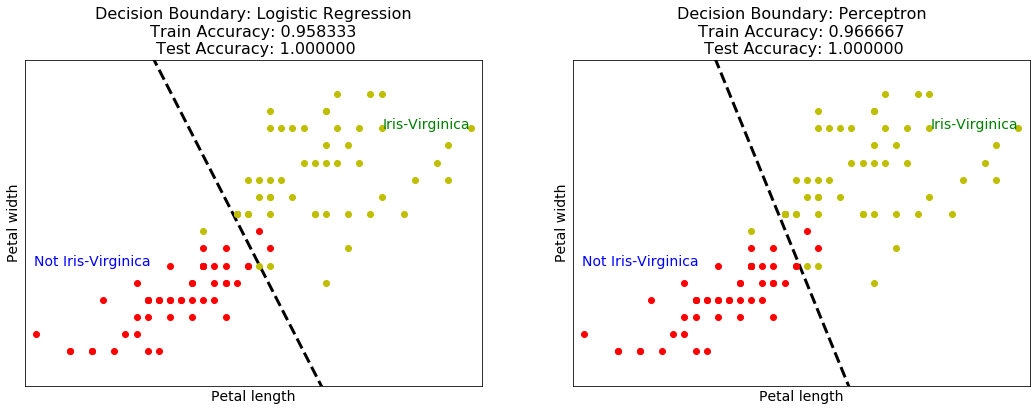

In [10]:
plt.figure(figsize=(18,6))

plt.subplot(121)
decision_boundary_equation_based(lg_reg_clf, X)
plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "ro")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("Decision Boundary: Logistic Regression\n Train Accuracy: %f \n Test Accuracy: %f"% 
          (train_accuracy_logreg, test_accuracy_logreg) , fontsize=16)
plt.axis([2.9, 7, 0.8, 2.7])
plt.xticks(())
plt.yticks(())


plt.subplot(122)
decision_boundary_equation_based(perceptron_clf, X)
plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "ro")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("Decision Boundary: Perceptron\n Train Accuracy: %f \n Test Accuracy: %f"% 
          (train_accuracy_perceptron, test_accuracy_perceptron) , fontsize=16)
plt.axis([2.9, 7, 0.8, 2.7])
plt.xticks(())
plt.yticks(())

plt.show()

## Decision Boundary II: Class Probability Based

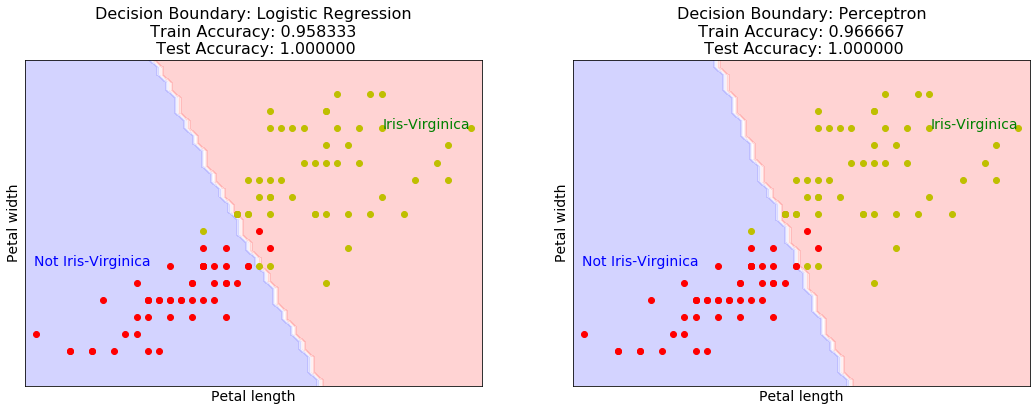

In [11]:
plt.figure(figsize=(18,6))

plt.subplot(121)
decision_boundary_class_colored(lg_reg_clf, X, plotDistanceFromHyperplane=False)
plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "ro")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("Decision Boundary: Logistic Regression\n Train Accuracy: %f \n Test Accuracy: %f"% 
          (train_accuracy_logreg, test_accuracy_logreg) , fontsize=16)
plt.axis([2.9, 7, 0.8, 2.7])
plt.xticks(())
plt.yticks(())


plt.subplot(122)
decision_boundary_class_colored(perceptron_clf, X, plotDistanceFromHyperplane=False)
plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "ro")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("Decision Boundary: Perceptron\n Train Accuracy: %f \n Test Accuracy: %f"% 
          (train_accuracy_perceptron, test_accuracy_perceptron) , fontsize=16)
plt.axis([2.9, 7, 0.8, 2.7])
plt.xticks(())
plt.yticks(())

plt.show()

## Observation

We see that for a linearly separable data set, the performance of Perceptron and Logistic Regression is similar. Because both are **linear models**.

A Linear Model is able to classify data when it is linearly separable. However, for non-linear data, it is unable to make clear separation. We will see this in the next notebook and will use a non-linear model for classifying complex data.